# PID  of two Lorenz systems
# with delayed interaction from 1 to 2

 Update history:
        March 10, 2019 creatin by CKC
        
        June 12, 2019, with Grange Causality test added by CKC
        
        Feb 16, 2021 for PID with Leo's code
       
        

In [1]:
import numpy as np
from random import gauss
from math import sqrt
import matplotlib as mpl
mpl.use('nbagg')
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Functions from Leo 

## EqualState assign states with equal possibility for input array x
def EqualState(x, num_state):
    xs=np.sort(x)
    binlen=int(len(x)/num_state-0.5) #round
    edges = xs[np.arange(num_state+1)*binlen]
    xstate=np.zeros(len(x))
    for i in range(num_state):
        xstate[x>=edges[i]] = i
    xstate = xstate.astype(int)
    return xstate, edges

# 
def PIfunc(r, x, v, dt, window):
    negshift=window[0] # second
    posshift=window[1] # second
    shiftlen=(posshift-negshift)/dt+1
    timeshift=np.linspace(negshift,posshift,int(shiftlen))
    bitshift=np.linspace(negshift/dt,posshift/dt,int(shiftlen),dtype = 'int16')
    Information = dict()
    Information[('BROJA_2PID','SI')]=np.zeros(len(bitshift))
    Information[('BROJA_2PID','UIx')]=np.zeros(len(bitshift))
    Information[('BROJA_2PID','UIv')]=np.zeros(len(bitshift))
    Information[('BROJA_2PID','CI')]=np.zeros(len(bitshift))
    Information[('Beer','Red')]=np.zeros(len(bitshift))
    Information[('Beer','UIx')]=np.zeros(len(bitshift))
    Information[('Beer','UIv')]=np.zeros(len(bitshift))
    Information[('Beer','Syn')]=np.zeros(len(bitshift))
    
    Information[('test','SI')]=np.zeros(len(bitshift))
    Information[('test','UIx')]=np.zeros(len(bitshift))
    Information[('test','UIv')]=np.zeros(len(bitshift))
    Information[('test','CI')]=np.zeros(len(bitshift))
    Redun =np.zeros(len(bitshift))
    MIxr=np.zeros(len(bitshift))
    MIvr=np.zeros(len(bitshift))
    MIxvR=np.zeros(len(bitshift))
    parms = dict()
    parms['max_iters'] = 20
    # shifted data
    # shift>0 => y shifted to positive side
    for i in range(len(bitshift)):
        xx=[]
        vv=[]
        rr=[]
        shift=bitshift[i]
        if shift>0:
            xx=x[shift:]
            vv=v[:(-1*shift)]
            rr=r[:(-1*shift)]
        elif shift==0:
            xx=x
            vv=v
            rr=r
        elif shift<0:
            xx=x[:shift]
            vv=v[(-1*shift):]
            rr=r[(-1*shift):]
        #find weight of each states by 3D histogram 
        xedges = np.append(np.unique(xx),(max(xx)+1))
        vedges = np.append(np.unique(vv),(max(vv)+1))
        redges = np.append(np.unique(rr),(max(rr)+1))
        dat = np.concatenate((xx[:,np.newaxis], vv[:,np.newaxis],rr[:,np.newaxis]), axis=1)
        N, edges = np.histogramdd(dat, bins=(xedges, vedges, redges))
        #Calculate all kinds of probability and make sure the shape of them, 0 -> x, 1 -> v, 2 -> r
        px=(np.sum(N,axis=(1,2))/np.sum(N))[:, np.newaxis, np.newaxis]
        pv=(np.sum(N,axis=(0,2))/np.sum(N))[np.newaxis, :, np.newaxis]
        pr=(np.sum(N,axis=(0,1))/np.sum(N))[np.newaxis ,np.newaxis, :]
        pxv=(np.sum(N,axis=2)/np.sum(N))[:, :, np.newaxis]
        pxr=(np.sum(N,axis=1)/np.sum(N))[:, np.newaxis, :]
        pvr=(np.sum(N,axis=0)/np.sum(N))[np.newaxis, :, :]
        pxvr=(N/np.sum(N))
        
        Information[('test','UIx')][i] = np.nansum(pxvr*np.log2(pxvr*px/pxv/pxr))/dt
        Information[('test','UIv')][i] = np.nansum(pxvr*np.log2(pxvr*pv/pxv/pvr))/dt
                
#         PDF=Histo3D2Dict(pxvr)
#         BROJA_2PID = pid(PDF, cone_solver="ECOS", output=0, **parms)
#         Information[('BROJA_2PID','SI')][i]=BROJA_2PID['SI']/dt
#         Information[('BROJA_2PID','UIx')][i]=BROJA_2PID['UIY']/dt
#         Information[('BROJA_2PID','UIv')][i]=BROJA_2PID['UIZ']/dt
#         Information[('BROJA_2PID','CI')][i]=BROJA_2PID['CI']/dt
        

        MIxr=np.nansum(pxr*np.log2(pxr/px/pr))/dt
        MIvr=np.nansum(pvr*np.log2(pvr/pv/pr))/dt
        MIxvR=np.nansum(pxvr*np.log2(pxvr/pxv/pr))/dt
        PI_xR = np.nansum(pxr*np.log2(pxr/px/pr), axis = (0,1))
        PI_vR = np.nansum(pvr*np.log2(pvr/pv/pr), axis = (0,1))
        R = sum(np.minimum(PI_xR, PI_vR))/dt
        Information[('Beer','Red')][i] = R
        Information[('Beer','UIx')][i] = MIxr - R
        Information[('Beer','UIv')][i] = MIvr - R
        Information[('Beer','Syn')][i] = MIxvR - MIxr - MIvr + R

    return timeshift, Information

In [3]:
# parameters for the Lorenz system

npts = 100000
x1 = np.zeros(npts)
y1 = np.zeros(npts)
z1 = np.zeros(npts)

x2 = np.zeros(npts)
y2 = np.zeros(npts)
z2 = np.zeros(npts)

sigma = 10.0
rho = 28.
beta = 8/3.
dt = 0.005

x1[0] = -7.0
y1[0] = 0.1
z1[0] = -1.0

x2[0] = -7.1
y2[0] = 0.2
z2[0] = -0.9

'''
x2[0] = -7.0
y2[0] = 0.1
z2[0] = -1.0

x1[0] = -7.1
y1[0] = 0.2
z1[0] = -0.9
'''

dt = 0.001
tau = 0.1
delay = int(tau/dt)

delay

100

In [4]:
# two non-interacting Lorenz systems
# from t =0 to t= delay

for i in range(1,delay+1):
    dx1 = sigma*(y1[i-1]-x1[i-1])*dt
    dy1 = (x1[i-1]*(rho - z1[i-1]) - y1[i-1])*dt
    dz1 = (x1[i-1]*y1[i-1] - beta*z1[i-1])*dt
    
    x1[i] = x1[i-1] + dx1
    y1[i] = y1[i-1] + dy1
    z1[i] = z1[i-1] + dz1

    dx2 = sigma*(y2[i-1]-x2[i-1] )*dt
    dy2 = (x2[i-1]*(rho - z2[i-1]) - y2[i-1])*dt
    dz2 = (x2[i-1]*y2[i-1] - beta*z2[i-1])*dt
    
    x2[i] = x2[i-1] + dx2
    y2[i] = y2[i-1] + dy2
    z2[i] = z2[i-1] + dz2

In [5]:
# two Lorenz systems with delay interaction from 1 to 2
# only in the x direction starting from t = delay+1

kx1 = 0.0
ky1 = 0.0
kz1 = 0.0

kx2 = 2.0
kx2 = 1.0
ky2 = 0.0
kz2 = 0.0

for i in range(delay+1,npts):
    int_x12 = kx2*(x1[i-1]-x2[i-delay-1])
    int_y12 = ky2*(y1[i-1]-y2[i-delay-1])
    int_z12 = kz2*(z1[i-1]-z2[i-delay-1])
    
    dx2 = sigma*(y2[i-1]-x2[i-1] +             int_x12)*dt
    dy2 = (x2[i-1]*(rho - z2[i-1]) - y2[i-1] + int_y12)*dt
    dz2 = (x2[i-1]*y2[i-1] - beta*z2[i-1] +    int_z12)*dt
    
    x2[i] = x2[i-1] + dx2
    y2[i] = y2[i-1] + dy2
    z2[i] = z2[i-1] + dz2

#for i in range(delay,npts):    
    
    int_x21 = kx1*(x2[i-1]-x1[i-delay-1])
    int_y21 = ky1*(y2[i-1]-y1[i-delay-1])
    int_z21 = kz1*(z2[i-1]-z1[i-delay-1])
    
    dx1 = sigma*(y1[i-1]-x1[i-1] +             int_x21)*dt
    dy1 = (x1[i-1]*(rho - z1[i-1]) - y1[i-1] + int_y21)*dt
    dz1 = (x1[i-1]*y1[i-1] - beta*z1[i-1] +    int_z21)*dt
    
    x1[i] = x1[i-1] + dx1
    y1[i] = y1[i-1] + dy1
    z1[i] = z1[i-1] + dz1


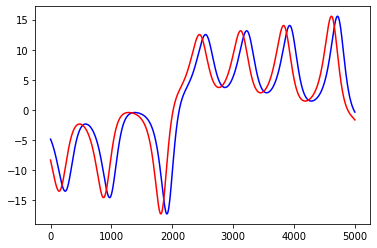

In [6]:
# x1 (master) and x2 (slave) are now synchronized.
# with x2 (red) head of x1

n1=40000
n0 =35000
plt.plot(x1[n0:n1],'b')
plt.plot(x2[n0:n1],'r')

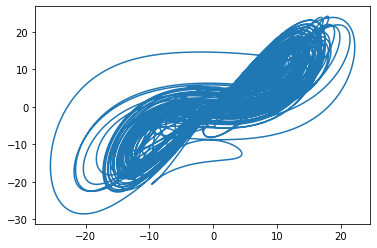

In [7]:
plt.plot(x2,y2)

In [8]:
# using numpy's histogram2d to calculate the mutual information between two sequences
def mi_quick(a,b,d,bn=25):
    if d>0: xy,_,_ = np.histogram2d(a[d:],b[:-d],bn)
    elif d<0: xy,_,_ = np.histogram2d(a[:d],b[-d:],bn)
    else: xy,_,_ = np.histogram2d(a,b,bn)
    xy /= np.sum(xy)
    px = [np.array([max(x,1e-100) for x in np.sum(xy,axis=0)])]
    py = np.transpose([[max(x,1e-100) for x in np.sum(xy,axis=1)]])
    nxy = (xy/px)/py
    nxy[nxy==0] = 1e-100
    return np.sum(xy*np.log2(nxy))

In [9]:
dms = range(-199,200)
mi_auto = [mi_quick(x2,x2,d) for d in dms]
mi_x12 = [mi_quick(x1,x2,d) for d in dms]


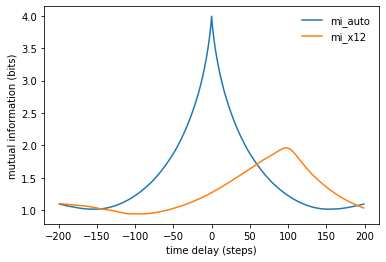

In [10]:
# Since x2 has the same structure of x1,
# it can be well ahead of x1 in mutual information

f,a = plt.subplots()
a.plot(dms,mi_auto,label='mi_auto')
a.plot(dms,mi_x12,label='mi_x12')
#a.set_xlim([-30,30])
a.legend(frameon=False)
a.set_ylabel('mutual information (bits)')
a.set_xlabel('time delay (steps)')
plt.show()

# starts of PID computation with a history length of 1 time step

In [11]:
# Generate x1n as history of x1np1 (np1 is short for n plus one)

npts = len(x1)
x1n = x1[0:npts-1].copy()
x2n = x2[0:npts-1].copy()
x1np1 = x1[1:npts].copy()
x2np1 = x2[1:npts].copy()


In [12]:
nstate = 8
x1np1_state, _= EqualState(x1np1, nstate)
x2np1_state, _= EqualState(x2np1, nstate)
x1n_state, _  = EqualState(x1n, nstate)
x2n_state, _  = EqualState(x2n, nstate)

In [15]:
dt=0.01
window=[-2,2]

dest_future = x2np1_state.copy()
source_hist = x1n_state.copy()
dest_hist   = x2n_state.copy()

timeshift, Information_list = PIfunc(dest_future, source_hist, dest_hist, dt, window)
# timeshift, Information_list = PIfunc(x2n_state, x2n_state, x1n_state, dt, window)
# timeshift, Information_list2 = PIfunc(x2n_state, x1n_state, x2n_state, dt, window)

C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:76: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:86: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered

<Figure size 800x600 with 0 Axes>

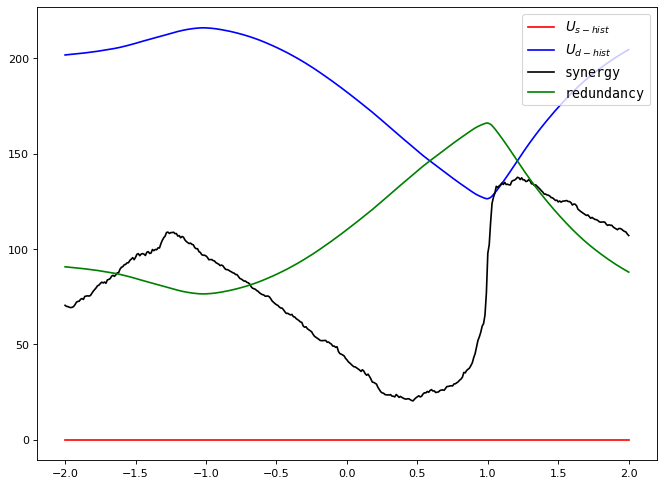

In [16]:
my_dpi=80
plt.figure(figsize=(800/my_dpi, 600/my_dpi), dpi=my_dpi)

Us = Information_list[('Beer','UIx')]
Ud = Information_list[('Beer','UIv')]
S  = Information_list[('Beer','Syn')]
R  = Information_list[('Beer','Red')]

plt.figure(figsize=(800/my_dpi, 600/my_dpi), dpi=my_dpi)
plt.plot(timeshift,Us*100, 'r-')
plt.plot(timeshift,Ud, 'b-')
plt.plot(timeshift,S*100, 'k-')
plt.plot(timeshift,R, 'g-')
plt.legend( ('$U_{s-hist}$', '$U_{d-hist}$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})

In [17]:
kx2

1.0

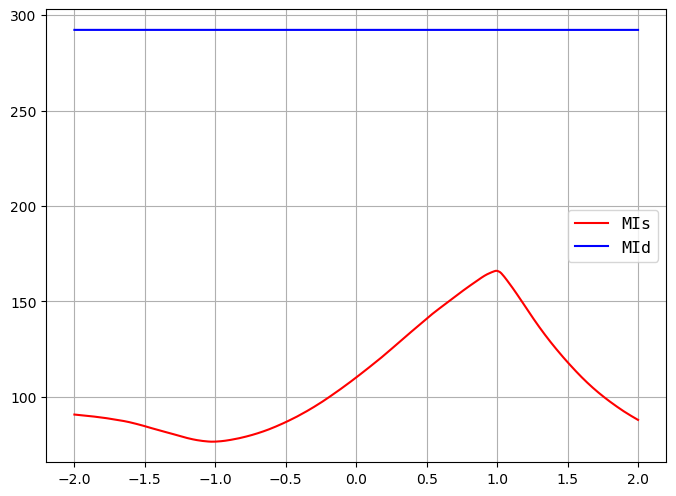

In [18]:
# Display MI to check if it is the same as above

my_dpi=100
plt.figure(figsize=(800/my_dpi, 600/my_dpi), dpi=my_dpi)
MIs = Us + R
MId = Ud + R

plt.plot(timeshift,MIs, 'r-')
plt.plot(timeshift,MId, 'b-')
#plt.plot(timeshift,Information_list[('Beer','UIx')]+Information_list[('Beer','Red')]+Information_list[('Beer','UIv')]+Information_list[('Beer','Syn')], 'k-')
#plt.plot(timeshift,Information_list[('Beer','UIx')]+2*Information_list[('Beer','Red')]+Information_list[('Beer','UIv')], 'm-')

plt.grid()
plt.legend( ('MIs', 'MId'), loc='best', prop={'size': 'large', 'family': 'monospace'})


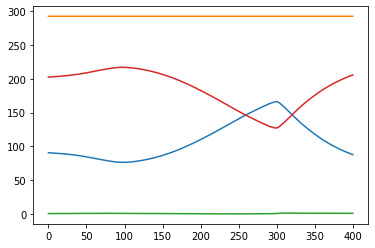

In [19]:
# Check Peter's calculation

plt.plot(Us+R)
plt.plot(Ud+R)
plt.plot(Us+S)
plt.plot(Ud+S)

# Longer history length

In [20]:
def calc_ent(x):
    if np.ndim(x)==2:
        x_value_list, x_value_counts = np.unique(x, axis=0, return_counts=True)
        ent = 0.0
        for x_value in x_value_list:
            p = float(x_value_counts[np.where((x_value==x_value_list).all(axis=1))]) / len(x) 
            logp = np.log2(p)
            ent -= p * logp
    elif np.ndim(x)==1:
        x_value_list, x_value_counts = np.unique(x, axis=0, return_counts=True)
        ent = 0.0
        for x_value in x_value_list:
            p = float(x_value_counts[np.where(x_value==x_value_list)]) / len(x) 
            logp = np.log2(p)
            ent -= p * logp        
        
    return ent

def MI(y, x1):
    # MI(x1;y) = ent(x1) - ent(x1|y)
    # calc ent(x1|y)
    if np.ndim(y)==1:
        y_value_list, y_value_counts = np.unique(y, axis=0, return_counts=True)
        
        ent1 = 0.0
        
        for y_value in y_value_list:
            sub_x1 = x1[np.where(y==y_value)]
            temp_ent = calc_ent(sub_x1)
            p = float(y_value_counts[np.where(y_value==y_value_list)]) / len(y)
            ent1 += p * temp_ent 
    elif np.ndim(y)==2:
        y_value_list, y_value_counts = np.unique(y, axis=0, return_counts=True)
        
        ent1 = 0.0
        
        for y_value in y_value_list:
            sub_x1 = x1[np.where((y==y_value).all(axis=1))]
            temp_ent = calc_ent(sub_x1)
            p = float(y_value_counts[np.where((y_value==y_value_list).all(axis=1))]) / len(y)
            ent1 += p * temp_ent        
    
    return calc_ent(x1) - ent1

def cond_MI(x_cond, y_cond, xt):
    # conditional MI(x_cond;xt|y_cond) = ent(x_cond|y_cond) - ent(x_cond|xt,y_cond)
    
    # construct xy_cond
    xt = np.reshape(xt, (1,len(xt)))
    xy_cond = np.concatenate((y_cond, xt.T), axis=1)

    y_value_list, y_value_counts = np.unique(y_cond, axis=0, return_counts=True)
    xy_value_list, xy_value_counts = np.unique(xy_cond, axis=0, return_counts=True)
    ent1 = 0.0
    ent2 = 0.0
    
    # calculate H(x_cond|y_cond)
    for y_value in y_value_list:
        sub_x = x_cond[np.where((y_cond==y_value).all(axis=1))]
        temp_ent = calc_ent(sub_x)
        py = float(y_value_counts[np.where((y_value==y_value_list).all(axis=1))]) / len(y_cond)
        ent1 += py * temp_ent

    # calculate H(x_cond|xt, y_cond)
    for xy_value in xy_value_list:
        sub_x2 = x_cond[np.where((xy_cond==xy_value).all(axis=1))]
        temp_ent2 = calc_ent(sub_x2)
        pxy = float(xy_value_counts[np.where((xy_value==xy_value_list).all(axis=1))]) / len(xy_cond)      
        ent2 += pxy * temp_ent2

    return ent1 - ent2

In [21]:
def pid_fig4(r, x, v, shift):
    if shift>0:
        xx=x[shift:]
        vv=v[:(-1*shift)]
        rr=r[:(-1*shift)]
    elif shift==0:
        xx=x
        vv=v
        rr=r
    elif shift<0:
        xx=x[:shift]
        vv=v[(-1*shift):]
        rr=r[(-1*shift):]
        
    dest_future = rr
    source_hist = xx
    dest_hist = vv
    
    m1 = MI(dest_future,dest_hist)
    m2 = MI(dest_future,source_hist)
    cm1 = cond_MI(dest_hist, source_hist, dest_future)
    cm2 = cond_MI(source_hist, dest_hist, dest_future)
    
    #print('Ud+R = ', m1)
    #print('Us+R = ', m2)

    #print('Ud+S = ', cm1)
    #print('Us+S = ', cm2)
    
    #print(m1+cm2)
    #print(m2+cm1)
    
    return m1, m2, cm1, cm2

In [22]:
h = 10 # history length
dms = np.arange(-199,200, 10)
dest_hist = np.array([x2n_state[i:i+h] for i in range(0,len(x2n_state)-h)])
source_hist = np.array([x1n_state[i:i+h] for i in range(0,len(x1n_state)-h)])
dest_future = np.array([x2n_state[i+h] for i in range(0, len(x2n_state)-h)])

m1 = []
m2 = []
cm1 = []
cm2 = []

for shift in dms:
    a,b,c,d = pid_fig4(dest_future, source_hist, dest_hist, shift)
    m1.append(a)
    m2.append(b)
    cm1.append(c)
    cm2.append(d)

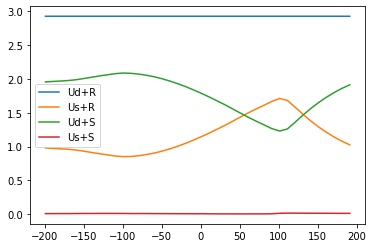

In [23]:
plt.figure
plt.plot(dms, m1, label='Ud+R')
plt.plot(dms, m2, label='Us+R')
plt.plot(dms, cm1, label='Ud+S')
plt.plot(dms, cm2, label='Us+S')
plt.legend()

# TE by Leo

In [42]:
def SimplifyState(x):
    output = np.zeros_like(x)
    states = np.sort(np.unique(x))
    counter = 0
    for state in states:
        output[np.where(x==state)] = counter
        counter += 1
    return output, np.arange(counter)

def StateList2D21D(x, statenum):
    output = np.zeros(x.shape[1])
    for i in range(x.shape[0]):
        output = output + x[i]*statenum**i
    return output

def TE(x, y, xhist_list, yhist_list):
    Information = dict()
    x, xstates = SimplifyState(x)
    y, ystates = SimplifyState(y)
    xdat = []
    ydat = []
    end = min(xhist_list[-1], yhist_list[-1])
    for hist in xhist_list:
        xhist = x[-end+hist:hist]
        xdat.append(xhist.copy())
        yhist = y[-end+hist:hist]
        ydat.append(yhist.copy())
    xhist = StateList2D21D( np.array(xdat), len(xstates))
    yhist = StateList2D21D( np.array(ydat), len(ystates))
    
    xedges = np.append(np.unique(xhist),(max(xhist)+1))
    vedges = np.append(np.unique(yhist),(max(yhist)+1))
    redges = np.append(np.unique(y),(max(y)+1))
    dat = np.concatenate((xhist[:,np.newaxis], yhist[:,np.newaxis],y[-end:,np.newaxis]), axis=1)
    N, edges = np.histogramdd(dat, bins=(xedges, vedges, redges))
    #Calculate all kinds of probability and make sure the shape of them, 0 -> x, 1 -> v, 2 -> r
    # x repersent x-hist
    # v repersent y-hist
    # r repersent y-now
    px=(np.sum(N,axis=(1,2))/np.sum(N))[:, np.newaxis, np.newaxis]
    pv=(np.sum(N,axis=(0,2))/np.sum(N))[np.newaxis, :, np.newaxis]
    pr=(np.sum(N,axis=(0,1))/np.sum(N))[np.newaxis ,np.newaxis, :]
    pxv=(np.sum(N,axis=2)/np.sum(N))[:, :, np.newaxis]
    pxr=(np.sum(N,axis=1)/np.sum(N))[:, np.newaxis, :]
    pvr=(np.sum(N,axis=0)/np.sum(N))[np.newaxis, :, :]
    pxvr=(N/np.sum(N))


    MIxr=np.nansum(pxr*np.log2(pxr/px/pr))
    MIvr=np.nansum(pvr*np.log2(pvr/pv/pr))
    print(MIvr)
    MIxvR=np.nansum(pxvr*np.log2(pxvr/pxv/pr))
    PI_xR = np.nansum(pxr*np.log2(pxr/px/pr), axis = (0,1))
    PI_vR = np.nansum(pvr*np.log2(pvr/pv/pr), axis = (0,1))
    R = sum(np.minimum(PI_xR, PI_vR))
    Information[('Beer','Red')] = R
    Information[('Beer','UIx2y')] = MIxr - R
    Information[('Beer','UIy2y')] = MIvr - R
    Information[('Beer','Syn')] = MIxvR - MIxr - MIvr + R

    return Information

In [44]:
hdms = np.arange(-199,0,10)
UIx2y = []
UIy2y = []
Red = []
Syn = []
for shift in hdms:
#     Information = TE(x1n_state, x2n_state, np.arange(shift,shift-10,-1), -np.arange(1,11))
    Information = TE(x1n_state, x2n_state, -np.arange(1,11), np.arange(shift,shift-10,-1) )
    UIx2y.append(Information[('Beer','UIx2y')])
    UIy2y.append(Information[('Beer','UIy2y')])
    Red.append(Information[('Beer','Red')])
    Syn.append(Information[('Beer','Syn')])

C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered i

2.9243378834165195
2.9243457567928495
2.924353527038993
2.924361194277522
2.924368758630811
2.9243762202210375
2.9243835791701818
2.924390835600027
2.9243979896321624
2.9244050413879785
2.924411990988674
2.924341670068732
2.9243488963299553
2.924356020396881
2.924363042390409
2.924369962431248
2.924376780639912
2.9243834971367226
2.9243901120418094
2.9243966254751097


In [46]:
Red = np.array(Red)
Syn = np.array(Syn)
UIx2y = np.array(UIx2y)
UIy2y = np.array(UIy2y)

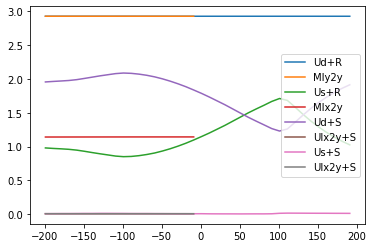

In [47]:
plt.figure
plt.plot(dms, m1, label='Ud+R')
plt.plot(hdms, Red+UIy2y, label='MIy2y')
plt.plot(dms, m2, label='Us+R')
plt.plot(hdms, Red+UIx2y, label='MIx2y')
plt.plot(dms, cm1, label='Ud+S')
plt.plot(hdms, Syn+UIx2y, label='UIx2y+S')
plt.plot(dms, cm2, label='Us+S')
plt.plot(hdms, Syn+UIx2y, label='UIx2y+S')
plt.legend()

In [27]:
x = x1n_state
y = x2n_state
xhist_list = np.arange(shift,shift-10,-2)
yhist_list = -np.arange(1,11)


xedge = np.append(np.unique(x),(max(x)+1))
yedge = np.append(np.unique(y),(max(y)+1))
dat = []
edges = []
end = min(xhist_list[-1], yhist_list[-1])
for hist in xhist_list:
    xhist = x[-end+hist:hist]
    dat.append(xhist.copy())
    edges.append(xedge)
for hist in yhist_list:
    yhist = y[-end+hist:hist]
    dat.append(yhist.copy())
    edges.append(yedge)
dat.append(y[-end:])
edges.append(yedge)

In [28]:
np.array(dat).shape

(16, 99792)

In [29]:
N, _ = np.histogramdd(np.array(dat).T, bins=edges)

MemoryError: Unable to allocate 63.2 PiB for an array with shape (8888888888888889,) and data type int64

# NO more lines below this line

In [ ]:
x1n_state